In [124]:
import dataclasses
from dataclasses import dataclass
from enum import Enum
from pathlib import Path
from typing import List

from IPython.display import display, JSON
from ipytree import Tree, Node
import ipywidgets as widgets
import plotly.graph_objects as go
from ruamel.yaml import YAML
from traitlets import Unicode

from openfisca_core.simulation_builder import SimulationBuilder
from openfisca_france import FranceTaxBenefitSystem

In [39]:
# Initialize tax and benefit system of France
tax_benefit_system = FranceTaxBenefitSystem()

In [40]:
PERIOD = "2019"

In [41]:
test_case = {
    "individus": {
        "Michel": {
            'date_naissance': {'ETERNITY': '1980-01-01'},
        },
    },
    "familles": {
        "famille_1": {
            "parents": ["Michel"]
        }
    },
    "foyers_fiscaux": {
        "foyer_fiscal_1": {
            "declarants": ["Michel"],
        },
    },
    "menages": {
        "menage_1": {
            "personne_de_reference": ["Michel"],
        }},
    "axes": [[
        {
            "name": 'salaire_de_base',
            "count": 101,
            "min": 0,
            "max": 100000,
            "period": PERIOD,
        },
    ]],
}


In [42]:
simulation_builder = SimulationBuilder()
simulation = simulation_builder.build_from_entities(tax_benefit_system, test_case)

In [43]:
salaire_de_base_arr = simulation.calculate_add("salaire_de_base", PERIOD)
display(salaire_de_base_arr)

array([     0.     ,    999.99994,   1999.9999 ,   3000.     ,
         3999.9998 ,   5000.     ,   6000.     ,   7000.0005 ,
         7999.9995 ,   9000.     ,  10000.     ,  11000.001  ,
        12000.     ,  12999.999  ,  14000.001  ,  15000.     ,
        15999.999  ,  17000.002  ,  18000.     ,  19000.     ,
        20000.     ,  21000.     ,  22000.002  ,  22999.998  ,
        24000.     ,  25000.002  ,  25999.998  ,  27000.     ,
        28000.002  ,  28999.998  ,  30000.     ,  31000.002  ,
        31999.998  ,  33000.     ,  34000.004  ,  34999.996  ,
        36000.     ,  37000.     ,  38000.     ,  39000.     ,
        40000.     ,  41000.     ,  42000.     ,  43000.     ,
        44000.004  ,  45000.     ,  45999.996  ,  47000.004  ,
        48000.     ,  48999.996  ,  50000.004  ,  51000.     ,
        51999.996  ,  53000.004  ,  54000.     ,  54999.996  ,
        56000.004  ,  57000.     ,  57999.996  ,  59000.004  ,
        60000.     ,  60999.996  ,  62000.004  ,  63000

In [44]:
revenu_disponible_arr = simulation.calculate("revenu_disponible", PERIOD)
display(revenu_disponible_arr)

array([ 6842.9014,  7362.618 ,  7908.988 ,  8442.072 ,  8975.147 ,
        9508.152 , 10041.235 , 10574.318 , 11107.323 , 11532.662 ,
       12175.397 , 12818.047 , 13460.794 , 14125.117 , 14811.8   ,
       15498.586 , 16185.369 , 16872.047 , 17558.836 , 18111.191 ,
       18625.477 , 19007.844 , 19377.207 , 19746.492 , 20115.86  ,
       20484.785 , 20839.098 , 21133.148 , 21513.95  , 22085.568 ,
       22775.309 , 23464.043 , 24153.668 , 24842.402 , 25532.129 ,
       26220.754 , 26910.488 , 27600.23  , 28199.229 , 28771.46  ,
       29347.09  , 29930.705 , 30514.447 , 31099.186 , 31682.81  ,
       32267.537 , 32851.266 , 33435.895 , 34019.625 , 34604.367 ,
       35187.99  , 35771.727 , 36356.457 , 36940.07  , 37524.816 ,
       38108.562 , 38692.176 , 39276.914 , 39860.645 , 40445.254 ,
       41028.996 , 41613.742 , 42197.35  , 42781.098 , 43365.816 ,
       43949.445 , 44534.176 , 45117.918 , 45701.535 , 46286.273 ,
       46870.016 , 47454.63  , 48038.375 , 48623.117 , 49206.7

## Display "Revenu disponible" interactively

In [45]:
@widgets.interact(salaire_de_base=widgets.SelectionSlider(options=salaire_de_base_arr))
def render(salaire_de_base):
    revenu_disponible = dict(zip(salaire_de_base_arr, revenu_disponible_arr))[salaire_de_base]
    return widgets.HBox([widgets.Label(f"Revenu disponible : {revenu_disponible:.2f}")])

interactive(children=(SelectionSlider(description='salaire_de_base', options=(0.0, 999.99994, 1999.9999, 3000.…

## Plot "Revenu disponible"

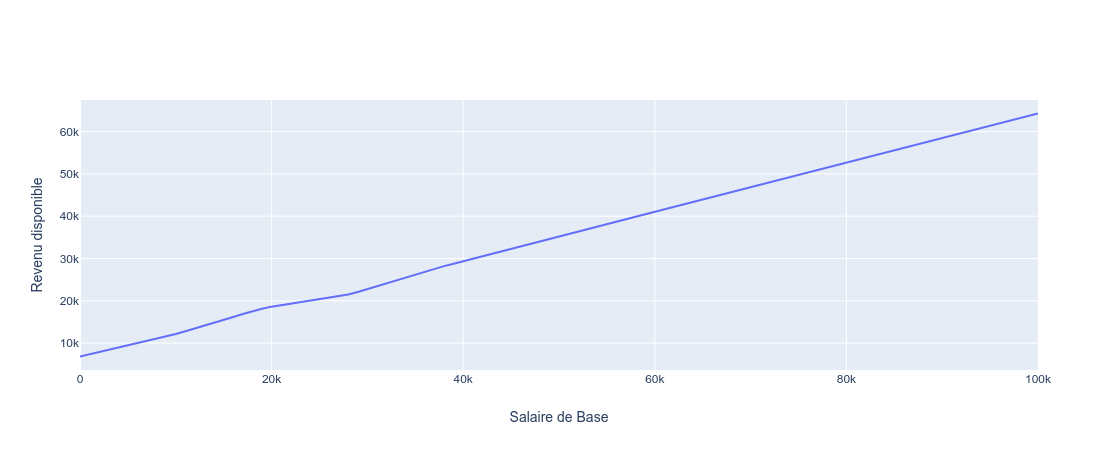

In [46]:
fig = go.Figure(
    data=go.Scatter(x=salaire_de_base_arr, y=revenu_disponible_arr),
    layout=go.Layout(xaxis_title="Salaire de Base", yaxis_title='Revenu disponible'),
)
fig.show()

## Display interactive waterfall

In [47]:
yaml = YAML(typ='safe')
decomposition = yaml.load(Path("./decomposition.yaml"))
JSON(decomposition)

<IPython.core.display.JSON object>

In [48]:
class BarType(Enum):
    VALUE = 1
    SUB_TOTAL = 2
    TOTAL = 3

In [49]:
@dataclass
class Bar:
    code: str
    type: BarType
    short_name: str = None
    value: float = None

In [50]:
def get_bars(decomposition: dict) -> List[Bar]:
    def visit(node):
        children = node.get("children")
        if children:
            for child in children:
                yield from visit(child)
            type_ = BarType.TOTAL if node["code"] == decomposition["code"] else BarType.SUB_TOTAL
            yield Bar(code=node["code"], short_name=node.get("short_name"), type=type_)
        else:
            yield Bar(code=node["code"], short_name=node.get("short_name"), type=BarType.VALUE)

    return list(visit(decomposition))

In [51]:
bars = get_bars(decomposition)
display(bars)

[Bar(code='cout_du_travail', type=<BarType.VALUE: 1>, short_name='Coût du travail', value=None),
 Bar(code='credit_impot_competitivite_emploi', type=<BarType.VALUE: 1>, short_name='CICE', value=None),
 Bar(code='aide_premier_salarie', type=<BarType.VALUE: 1>, short_name='Aide premier salarié', value=None),
 Bar(code='aide_embauche_pme', type=<BarType.VALUE: 1>, short_name='Aide PME', value=None),
 Bar(code='tehr', type=<BarType.VALUE: 1>, short_name='Taxe exceptionnelle', value=None),
 Bar(code='salaire_super_brut', type=<BarType.SUB_TOTAL: 2>, short_name='Salaire super brut', value=None),
 Bar(code='allegement_fillon', type=<BarType.VALUE: 1>, short_name='Fillon', value=None),
 Bar(code='salaire_super_brut_hors_allegements', type=<BarType.SUB_TOTAL: 2>, short_name='Salaire super brut HA', value=None),
 Bar(code='cotisations_employeur', type=<BarType.VALUE: 1>, short_name='Cotisations employeur', value=None),
 Bar(code='salaire_de_base', type=<BarType.SUB_TOTAL: 2>, short_name='Salaire

In [52]:
results = {
    bar.code: simulation.calculate_add(bar.code, period=PERIOD)
    for bar in bars
}

In [53]:
def iter_displayed_bars(bars: List[Bar], results: dict, salaire_de_base: float, include_subtotals: bool, include_zero: bool):
    for bar in bars:
        if bar.type == BarType.SUB_TOTAL and not include_subtotals:
            continue
        value = dict(zip(salaire_de_base_arr, results[bar.code]))[salaire_de_base]
        if include_zero or value != 0:
            yield dataclasses.replace(bar, value=value)  

In [125]:
class BarNode(Node):
    code = Unicode()

In [184]:
def get_root_node(decomposition: dict, results: dict, salaire_de_base: float, include_subtotals: bool, include_zero: bool) -> Node:
    def visit(node):
        children = node.get("children")
        value = dict(zip(salaire_de_base_arr, results[node["code"]]))[salaire_de_base]
        if value == 0 and not include_zero:
            return
        # Cf https://fontawesome.com/icons?d=gallery&m=free
        icon = "folder" if children else "arrow-down" if value < 0 else "arrow-up"
        text_value = ("{:.0f}" if children else "{:+.0f}").format(value)
        name = node.get("short_name") or node["code"]
        node = BarNode(f"{name} ({text_value})", code=node["code"], icon=icon)
        if children:
            node.nodes = list(filter(None, (visit(child) for child in children)))
        return node

    return visit(decomposition)

In [185]:
def update_plot(*args):
    tree.nodes = [get_root_node(decomposition, results, salaire_de_base=slider.value,
                                include_subtotals=include_subtotals.value, include_zero=include_zero.value)]
    displayed_bars = list(iter_displayed_bars(bars, results, salaire_de_base=slider.value,
                                              include_subtotals=include_subtotals.value, include_zero=include_zero.value))
    with fig.batch_update():
        waterfall = fig.data[0]
        waterfall.x = [bar.short_name or bar.code for bar in displayed_bars]
        waterfall.y = [
            bar.value if bar.type == BarType.VALUE else 0
            for bar in displayed_bars
        ]
        waterfall.measure = [
            "relative" if bar.type == BarType.VALUE else "total"
            for bar in displayed_bars
        ]
#         waterfall.selectedpoints = [1, 3]
        waterfall.customdata = [{"code": bar.code} for bar in displayed_bars]
        waterfall.text = [
            ("{:+.0f}" if bar.type == BarType.VALUE else "{:.0f}").format(bar.value)
            for bar in displayed_bars
        ]

In [186]:
include_subtotals = widgets.Checkbox(description="Afficher les sous-totaux")
include_subtotals.observe(update_plot, 'value')

include_zero = widgets.Checkbox(description="Afficher les valeurs 0")
include_zero.observe(update_plot, 'value')

slider = widgets.SelectionSlider(options=salaire_de_base_arr)
slider.observe(update_plot, 'value')

waterfall = go.Waterfall(textposition="inside")

output = widgets.Output()

def select_tree_node(tree, code):
    def visit(node):
        for child in node.nodes:
            child.selected = child.code == code
            if child.nodes:
                select_tree_node(child, code)

    visit(tree)
        
@output.capture()
def on_hover(trace, points, selector):
    code = trace.customdata[points.point_inds[0]]["code"]
    select_tree_node(tree, code)

layout = go.Layout()
fig = go.FigureWidget(data=[waterfall], layout=layout)
fig.data[0].on_hover(on_hover)

tree = Tree()

update_plot()

widgets.VBox([
    output,
    widgets.HBox([widgets.Label('Salaire de base'), slider]),
    widgets.HBox([include_subtotals, include_zero]),
    widgets.HBox([tree, fig]),
])

## Display bareme

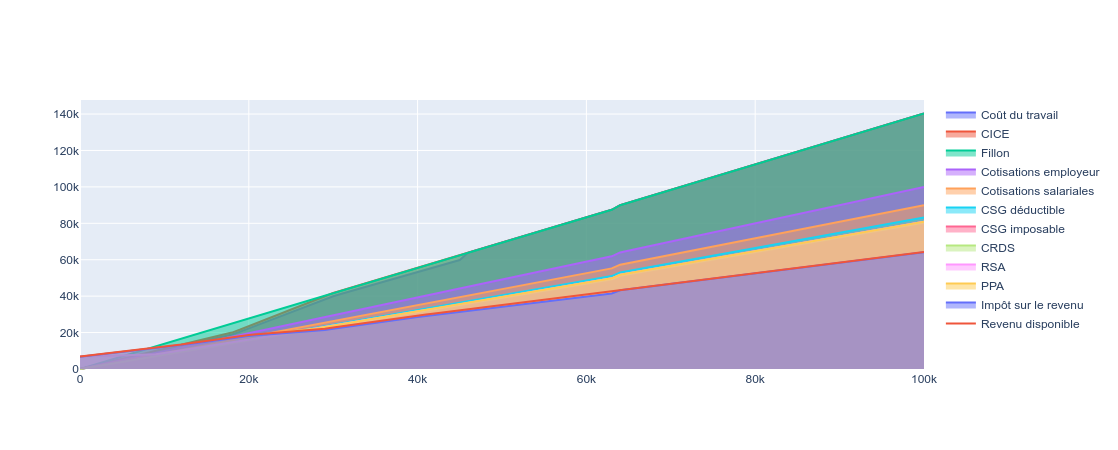

In [20]:
areas = [
    go.Scatter(
        x=salaire_de_base_arr,
        y=results[bar.code],
        name=bar.short_name or bar.code,
        text=bar.short_name or bar.code,
        stackgroup='one',
        fill='tozeroy',
    #     fillcolor='darkviolet',
        hoveron = 'points+fills', # select where hover is active
        hoverinfo = 'text+x+y',
    )
    for bar in bars
    if bar.type == BarType.VALUE and (results[bar.code] != 0).any()
]
lines = [
    go.Scatter(
        x=salaire_de_base_arr,
        y=results[bar.code],
        name=bar.short_name or bar.code,
        text=bar.short_name or bar.code,
        hoverinfo = 'text+x+y',
    )
    for bar in bars
    if bar.type == BarType.TOTAL
]
fig = go.Figure(data=areas + lines)
fig.show()